In [2]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import math

def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 4
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "logloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.8
    param['colsample_bytree'] = 0.8
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model
    
data_path = "./input/"
train_file = data_path + "train.json"
test_file = data_path + "test.json"
train_df = pd.read_json(train_file)
test_df = pd.read_json(test_file)
print(train_df.shape)
print(test_df.shape)

features_to_use  = ["bathrooms", "bedrooms", "latitude", "longitude", "price"]

# transformation of lat and lng #
train_df["price_t"] = train_df["price"]/train_df["bedrooms"] 
test_df["price_t"] = test_df["price"]/test_df["bedrooms"] 

train_df["room_dif"] = train_df["bedrooms"]-train_df["bathrooms"] 
train_df["room_sum"] = train_df["bedrooms"]+train_df["bathrooms"] 
train_df["price_t1"] = train_df["price"]/train_df["room_sum"]
train_df["fold_t1"] = train_df["bedrooms"]/train_df["room_sum"]

test_df["room_dif"] = test_df["bedrooms"]-test_df["bathrooms"] 
test_df["room_sum"] = test_df["bedrooms"]+test_df["bathrooms"] 
test_df["price_t1"] = test_df["price"]/test_df["room_sum"]
test_df["fold_t1"] = test_df["bedrooms"]/test_df["room_sum"]

 
# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

# convert the created column to datetime object so as to extract more features 
train_df["created"] = pd.to_datetime(train_df["created"])
train_df["passed"] = train_df["created"].max() - train_df["created"]

test_df["created"] = pd.to_datetime(test_df["created"])
test_df["passed"] = test_df["created"].max() - test_df["created"]
# Let us extract some features like year, month, day, hour from date columns #
train_df["created_year"] = train_df["created"].dt.year
test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = train_df["created"].dt.hour
test_df["created_hour"] = test_df["created"].dt.hour


# Add the number of exclamation signs:
#train_df['num_exclamations'] = train_df['description'].apply(lambda x: len(x.split('!')))
#test_df['num_exclamations'] = test_df['description'].apply(lambda x: len(x.split('!')))

# adding all these new features to use list #
features_to_use.extend(["price_t","num_photos", "num_features", "num_description_words", 
                        "created_year", "created_month", "created_day", "created_hour",
                        "listing_id",'room_dif','room_sum','price_t1'])
                        
categorical = ["display_address", "manager_id", "building_id", "street_address"]
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)
            
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
print(train_df["features"].head())
tfidf = CountVectorizer(stop_words='english', max_features=400)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])


'''
tfidf = TfidfVectorizer(stop_words='english', max_features=50)
tr_sparse2 = tfidf.fit_transform(train_df["description"])
te_sparse2 = tfidf.transform(test_df["description"])
'''
#0.5459
'''
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse2 = tfidf.fit_transform(train_df["description"])
te_sparse2 = tfidf.transform(test_df["description"])
'''
'''
tfidf = TfidfVectorizer(stop_words='english', max_features=50)
tr_sparse2 = tfidf.fit_transform(train_df["street_address"])
te_sparse2 = tfidf.transform(test_df["street_address"])
'''



train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape)

'''
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break
'''

preds, model = runXGB(train_X, train_y, test_X, num_rounds=1000)
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("xgb_starter_1.csv", index=False)

(49352, 15)
(74659, 14)
10                                                         
10000     Doorman Elevator Fitness_Center Cats_Allowed D...
100004    Laundry_In_Building Dishwasher Hardwood_Floors...
100007                               Hardwood_Floors No_Fee
100013                                              Pre-War
Name: features, dtype: object
((49352, 421), (74659, 421))


In [3]:
! ls 

001_eda.ipynb                        301_submit_julcsi.ipynb
002_merge.ipynb                      301_submit_julcsi_with_tfidfs.ipynb
003_split.ipynb                      301_submit_peti.ipynb
101_bathrooms.ipynb                  Duplicated listings.ipynb
102_bedrooms.ipynb                   Majom scriptje.ipynb
103_building_id.ipynb                Untitled.ipynb
104_created.ipynb                    first_try.csv
105_description.ipynb                generate_features.sh
106_display_address.ipynb            input
107_features.ipynb                   output
108_latlon_clustering.ipynb          raw_data.csv
109_manager_id.ipynb                 readme.txt
110_photos.ipynb                     second_try.csv
111_price.ipynb                      tmp
112_street_address.ipynb             v1
201_feature_importances_julcsi.ipynb v2
201_feature_importances_peti.ipynb   xgb_starter_1.csv


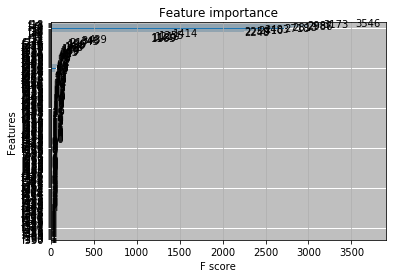

In [10]:
%matplotlib inline
xgb.plot_importance(model)

In [24]:
feature_importance_score = model.get_fscore()

In [26]:
# non-tfidf features by Majom

feature_importance = {}
for i, f in enumerate(features_to_use):
    feature_name = 'f{}'.format(i)
    feature_importance[f] = feature_importance_score.get(feature_name, 0)
feature_importance

{'bathrooms': 196,
 'bedrooms': 348,
 'building_id': 2813,
 'created_day': 1180,
 'created_hour': 1165,
 'created_month': 125,
 'created_year': 0,
 'display_address': 2483,
 'latitude': 2987,
 'listing_id': 3173,
 'longitude': 2718,
 'manager_id': 3546,
 'num_description_words': 2248,
 'num_features': 1210,
 'num_photos': 1255,
 'price': 2986,
 'price_t': 1414,
 'price_t1': 2250,
 'room_dif': 439,
 'room_sum': 188,
 'street_address': 2410}

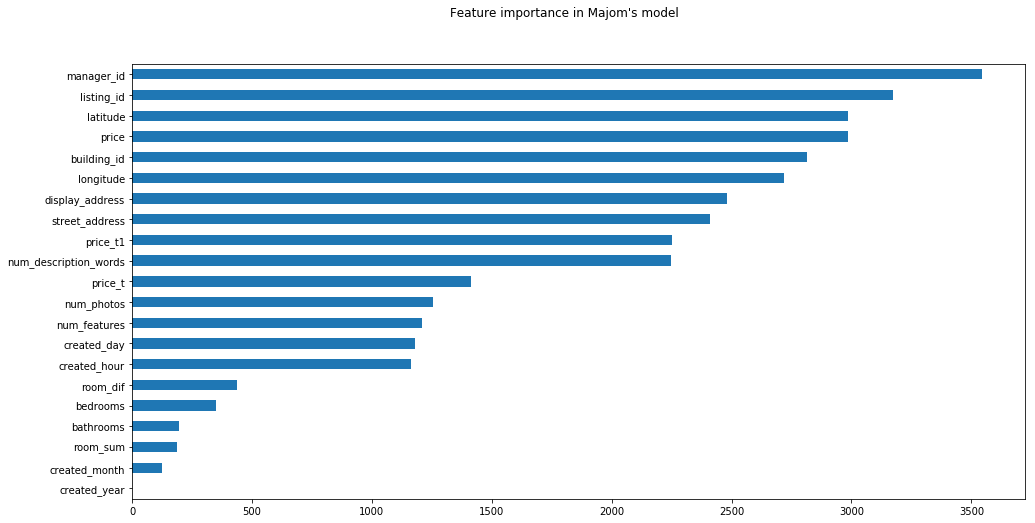

In [34]:
import pylab as pl
pd.Series(feature_importance).sort_values().plot(kind='barh', figsize=(16, 8))
pl.suptitle("Feature importance in Majom's model")